## Metrics for GW Imaging

The traditional metric for exploring new GW missions is a sensitivity curve showing sensitivity to GW signals as a function of frequency.  Here we assemble tools for computing metrics from basic design parameters. Useful metric are:
- Sensitivity
- Diffraction Limited Resolution
- Astrometric Precision

This notebook copies and adapts significantly from code to be released with an upcoming LISA Consoritum technical note to define standards for LISA sensitivity calculations. (*Need a reference*)

To run this on Google Colab:
markdown
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnGBaker/GWI-metrics/blob/main/Notebooks/MetricsNotebook.ipynb)

### Some basic setup

In [1]:
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/JohnGBaker/GWI-metrics.git
    src='GWI-metrics/src/'
else:
    src='../src/'
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append(src)
import metrics
import concepts

### Define mission concept model parameters
We use a dictionary to collect the basic relevant mission parameters.  For now we just have a few basic params an LISA as a reference case.

For the LISASciRDv1 example we provide explicit values for the core noise levels. We have allowed for providing a function which derives these based on lower-level parameters as well.
Some parameters:

| Name         | Units             | Description |
| :- | :- | :- |
| sqSacc_level | $m/s^2/\sqrt{Hz}$ | Acceleration noise level     |
| sqSacc_func  | --                | Function to compute acceleration noise level     |
| sqSoms_level | $m/\sqrt{Hz}$     | Optical metrology system noise level     |
| sqSoms_func  | --                | Function to compute optical metrology system noise level     |
| Lconst       | $m$               | Constellation armlength scale |
| Rorbit       | AU                | Size of orbit |
| Torbit       | yr                | Period of orbit |
| Dsep         | AU                | Distance separating multiple constellations |
| Nindep       | --                | Number of independent GW channels  |

In [2]:
'''
LISASciRDv1 = {
    'label' : 'LISA(SciRDv1)',
    'sqSacc_level' : 3e-15,
    'sqSoms_level' : 15e-12,
    'Lconst' : 2.5e9,
    'Dsep' : 0,
    'Rorbit' : 1.0,
    'Torbit' : 1.0,
    'Nindep' : 2
}
'''
LISASciRDv1=concepts.LISASciRDv1

### Make PSD Noise Components
We follow LISA in computing the noise. In that case the noise is more-or-less directly derived from 
- a measure of the acceleration noise in $m/s^2/\sqrt(Hz)$ with some additional reddening factors
- a measure of optical measurement system noise in $m/\sqrt(Hz)$
The noise PSD is reported in fractional frequency units

#Probably adapt more for GW Imager concepts 
def PSD_noise_components(fr, model):
    if 'sqSacc_level' in model:
        sqSacc_level = model.get('sqSacc_level') 
    else:
        sqSacc_level = model.get('sqSacc_func')(model) #Can provide a func here instesad of a value
    if 'sqSoms_level' in model:
        sqSoms_level = model.get('sqSoms_level')
    else:
        sqSoms_level = model.get('sqSoms_func')(model) #Can provide a func based Jeff's calculations
    
    c=constants['c']
    
    ### Acceleration noise
    Sa_a = sqSacc_level**2 *(1.0 +(0.4e-3/fr)**2)*(1.0+(fr/8e-3)**4)
    Sa_d = Sa_a*(2.*np.pi*fr)**(-4.)
    Sa_nu = Sa_d*(2.0*np.pi*fr/c)**2

    ### Optical Metrology System
    Soms_d = sqSoms_level**2 * (1. + (2.e-3/fr)**4)
    Soms_nu = Soms_d*(2.0*np.pi*fr/c)**2
    
    return [Sa_nu, Soms_nu]

## Sensitivity
### Core calculation
#### LISA Technical Note Expression

Using the semi-analytical average response, the semi-analytical sensitivity for TDI X 4 links is:
$$
S_{h,X} =  \frac{ S_{OMS} + \left( 3 + \cos \left( \frac{2 \omega L}{c} \right)  \right)  S_{acc} }
{ \left( {\omega L \over c} \right)^2 \ R_{\Sigma}^2(f, L) }
$$
$$
S_{h,X} 
=  \frac{S_{n,X_{2.0}}}
{<R_{L, X_{2.0}}(f)>} 
= \frac{ 64 \sin^2 \left( \omega L \right) \sin^2 \left(2 \omega L \right) (S_{OMS} + \left( 3 + \cos \left( \frac{2 \omega L}{c} \right)  \right)  S_{acc}) }
{ (4\omega L)^2 \sin^2{(\omega L)} (2 \sin{(2\omega L)})^2 <(F^{+}_{X})^2> }
= \frac{ S_{OMS} + \left( 3 + \cos \left( \frac{2 \omega L}{c} \right)  \right)  S_{acc} }
{ \left( \omega L \right)^2  <(F^{+}_{X})^2>  }
$$
#### Larson
Using the semi-analytical average response a la Larson, the semi-analytical sensitivity for TDI X 4 links is:
$$
S_{h, X}  =  \frac{ S_{OMS} + \left( 3 + \cos \left( \frac{2 \omega L}{c} \right)  \right)  S_{acc} }
{ \left( {\omega L \over c} \right)^2 \ R_{\Sigma}^2(f, L) }
$$

#### Arm response to GW
From the LISA technical note we use their analytic approximation of $<(F^{+}_{X})^2>$ rather than a time consuming or tabulated detailed calculation.

For the Larson version, we copy from the LISA TN in drawing from Larson et al. PRD 62,062001

$$
R_{\Sigma}(u) = \frac{1}{u^2} \left[ (1+ \cos^2 u) \left( \frac{1}{3} - \frac{2}{u^2} \right) +\sin^2 u + \frac{4}{u^3} \sin u \cos u \right] 
- \frac{1}{4 \pi} I_{\epsilon,\theta_1}(u)
$$
with $u = \omega L$ and the integral:
$$
I_{\epsilon,\theta_1}(u) = \int_0^{2 \pi} d \epsilon \int_0^{\pi} d \theta_1 \sin \theta_1 ( 1 - 2 \sin^2 \alpha ) \ \eta(u)
$$

$$
\eta(u) =  [\cos u - \cos(u \mu_1)] [\cos u - \cos(u \mu_2)] \mu_1 \mu_2 + [\sin u - \mu_1 \sin(u \mu_1)] [\sin u - \mu_2 \sin(u \mu_2)]
$$
$$
\sin(\alpha) = \frac{sin \gamma \sin \epsilon}{\sin \theta_2}
$$
$$
\cos \theta_2 = \cos \gamma \cos \theta_1 + \sin \gamma \sin \theta_1 \cos \epsilon
$$
 and $\mu_i = \cos \theta_i$

#Component for the LISA TN computation:
def AvFXp2_approx(fr,L):
    return 16.*(3./20.)*(1./(1.+0.6*(2.*np.pi*fr*L)**2))

#Components for the Larson computation
gamma = 60*180/np.pi
sg = np.sin(gamma)
cg = np.cos(gamma)
def fIte(eps,th1,u,cu,su,sg,cg):
    cth1 = np.cos(th1)
    sth1 = np.sin(th1)
    cth2 = cg*cth1+sg*sth1*np.cos(eps)
    sa = sg*np.sin(eps)/np.sqrt(1-cth2*cth2)
    eta = (cu-np.cos(u*cth1))*(cu-np.cos(u*cth2))*cth1*cth2+(su-cth1*np.sin(u*cth1))*(su-cth2*np.sin(u*cth2))
    #print(eps,th1,cth1,sth1,sa,eta,sa)
    return np.sin(th1)*(1-2*sa*sa)*eta

def Tarm(f,L):
    from scipy.integrate import dblquad
    w = 2*np.pi*f
    u = w*L
    cu = np.cos(u)
    su = np.sin(u)
    
    
    Iet = dblquad(fIte, 0, 2*np.pi, lambda x: 0, lambda x: np.pi, args=(u,cu,su,sg,cg))
    #print(Iet)
    return ((1+cu*cu)*(1./3.-2./(u*u))+su*su+4.*su*cu/(u*u*u))/(u*u) - Iet[0]/(4.*np.pi)

    
#Compute sensitivty curve
def makeSensitivity(fr, model,style='TN'):
    [Sa_nu,Soms_nu] = metrics.PSD_noise_components(fr, model)
    L=model.get('Lconst')
    N=model.get('Nindep')
    c=constants['c']
    phiL = 2*np.pi*fr*L/c
    if style=='TN':
        AvFXp2 = AvFXp2_approx(fr,L/c)
        S_hX = (Soms_nu + Sa_nu*(3.+np.cos(2*phiL)) ) / (phiL**2 * AvFXp2/4**2)#LISA TN
    elif style=='Larson': #This is very slow!
        yTarm = np.zeros(len(fr))
        for i in range(len(fr)):
            yTarm[i] = Tarm(fr[i],L)
        #renormalize as in TN
        yTarmN = yTarm/yTarm[0]
        yTarmRN = yTarmN * (np.sin(np.pi/3.)**2/5)
        S_hX = (Soms_nu + Sa_nu*(3+np.cos(2*phiL)) ) / (phiL**2 * yTarmRN)
    S_h = S_hX / N
    return S_h


QE: 0.8156855160078964
P_Rx: 8.444165217362159e-10
sqSn_shot: 2.764880922798791e-12
QE: 0.8156855160078964
P_Rx: 8.687412775063951e-10
sqSn_shot: 2.7258977704186754e-12


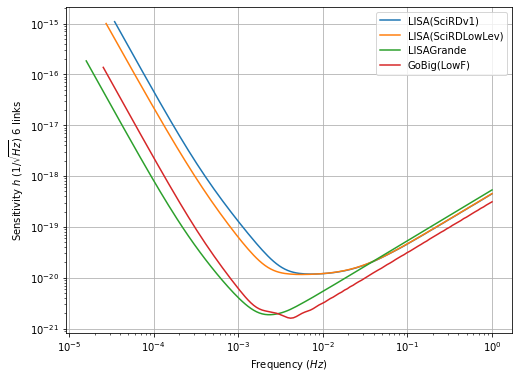

In [3]:
def plot_sens(models,fpowLow=-5,fpowHi=0,n=150):
    fr=np.logspace(fpowLow,fpowHi,n)
    plt.figure(figsize=[8,6])
    for model in models:
        S_h=metrics.makeSensitivity(fr, model)
        #trim range
        imin=0
        Smin=min(S_h)
        Scut=100000**2*Smin
        while S_h[imin]>Scut:imin+=1
        iend=len(S_h)
        while S_h[iend-1]>Scut:iend-=1        
        plt.loglog(fr[imin:iend],np.sqrt(S_h[imin:iend]),label=model.get('label'))
    plt.xlabel(r'Frequency ($Hz$)')
    plt.ylabel(r'Sensitivity $h$ ($1/\sqrt{Hz}$) 6 links')
    plt.grid()
    plt.legend()
    
models=[LISASciRDv1,concepts.LISASciRDLowLev,concepts.LISAGrande,concepts.GoBIGLowF]
plot_sens(models)

### Imaging
Here we construct two elementary figures of merit relevant for imaging, relevant for our imaging incoherent and our astrometric notions of imaging. 

The first is basically diffraction limited resolution for short or long duration sources concentrated at some rerference frequency. The estimate is:
$$
\Delta \theta_\mathrm{diff} \approx F \frac{\lambda}{D}
$$
Where we suppose $F\approx 1$ and
$$
\max(L_\mathrm{constellation},D_\mathrm{sep})\leq D \leq \max(2R_{orbit},L_\mathrm{constellation},D_\mathrm{sep})
$$
depending on how long the source lasts compared to $T_\mathrm{orbit}$.

The other is astrometric localization which is scaled by the SNR:
$$
\Delta \theta_\mathrm{am} \approx \Delta \theta_\mathrm{diff}/\rho
$$

There are a number of different ways we can think about making plots using these, including horizon distances for reference classes of obervations, etc. More thought is needed on what makes sense..

def dResRange(fr,model):
    D=model['Lconst']
    c=constants['c']
    au=constants['AU']*c
    if 'Dsep' in model: D=max([D,model['Dsep']*au])
    Dshort=D
    if 'Rorbit' in model: D=max([D,2*model['Rorbit']*au])
    Dlong=D
    dtheta_long=c/fr/Dlong
    dtheta_short=c/fr/Dshort
    return dtheta_long,dtheta_short


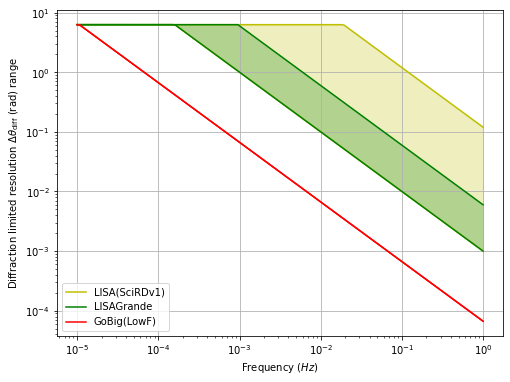

In [4]:
def plot_dRes(models,fpowLow=-5,fpowHi=0,n=150):
    colors=['b','y','g','r']
    fr=np.logspace(fpowLow,fpowHi,n)
    plt.figure(figsize=[8,6])
    dthetamax=2*np.pi
    i=0
    for model in models:
        i+=1
        dResLong,dResShort=metrics.dResRange(fr, model)
        plt.loglog(fr,np.clip(dResLong,None,dthetamax),label=model.get('label'),color=colors[i])
        plt.loglog(fr,np.clip(dResShort,None,dthetamax),color=colors[i])
        plt.fill_between(fr,np.clip(dResLong,None,dthetamax),np.clip(dResShort,None,dthetamax),color=colors[i],alpha=0.25)
    plt.xlabel(r'Frequency ($Hz$)')
    plt.ylabel(r'Diffraction limited resolution $\Delta\theta_\mathrm{diff}$ (rad) range')
    plt.grid()
    plt.legend()


models=[LISASciRDv1,concepts.LISAGrande,concepts.GoBIGLowF]
plot_dRes(models)
